# Introduction

In ecommerce companies like online retails, customer segmentation is necessary in order to understand customers behaviors. It leverages aqcuired customer data like the one we have in our case, **transactions data** in order to divide customers into groups. 

Our goal in this Notebook is to cluster our customers to get insights in:
- Increasing **revenue** (Knowing customers who present most of our revenue)
- Increasing customer **retention**
- Discovering **Trends and patterns** 
- Defining **customers at risk**

We will do **RFM Analysis** as a first step and then **combine RFM with predictive algorithms (k-means)**. 

RFM Analysis answers these questions:
- Who are our best customers?
- Who has the potential to be converted in more profitable customers?
- Which customers we must retain?
- Which group of customers is most likely to respond to our current campaign?


# Import modules

In [41]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt
import seaborn as sns


In [ ]:


#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GMM

from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

# Get the Data

In [3]:
#load the dataset
retail_df = pd.read_excel("Online Retail.xlsx")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Prepare the Data

As customer clusters may vary by geography, I’ll restrict the data to only United Kingdom customers, which contains most of our customers historical data.

In [4]:
retail_uk = retail_df[retail_df['Country']=='United Kingdom']
#check the shape
retail_uk.shape

(495478, 8)

In [5]:
#remove canceled orders
retail_uk = retail_uk[retail_uk['Quantity']>0]
retail_uk.shape

(486286, 8)

In [6]:
#remove rows where customerID are NA
retail_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_uk.shape

(354345, 8)

In [7]:
#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
retail_uk = retail_uk[retail_uk['InvoiceDate']>= "2010-12-09"]
retail_uk.shape

(342478, 8)

In [8]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", retail_uk['InvoiceNo'].nunique())
print("Number of products bought: ",retail_uk['StockCode'].nunique())
print("Number of customers:", retail_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(retail_uk['CustomerID'].isnull().sum() * 100 / len(retail_df),2),"%" )

Summary..
Number of transactions:  16017
Number of products bought:  3611
Number of customers: 3863
Percentage of customers NA:  0.0 %


# RFM Analysis

RFM (**Recency, Frequency, Monetary**) analysis is a customer segmentation technique that uses past purchase **behavior** to divide customers into groups. <br> RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.
- RECENCY (R): Days since last purchase 
- FREQUENCY (F): Total number of purchases 
- MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.


## Recency


To calculate recency, we need to choose a date point from which we evaluate **how many days ago was the customer's last purchase**.

In [9]:
#last date available in our dataset
retail_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

The last date we have is 2011-12-09 so we will use it as reference.

In [10]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [11]:
#create a new column called date which contains the date of invoice only
retail_uk['date'] = retail_uk['InvoiceDate'].dt.date

In [12]:
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09


In [13]:
#group by customers and check last date of purshace
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [14]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [15]:
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [16]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

Now we have the recency attribute created. e.g: Customer with ID = 12346 did his/her last purshace 325 days ago.

## Frequency

Frequency helps us to know **how many times a customer purchased from us**. To do that we need to check how many invoices are registered by the same customer.

In [17]:
# drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


## Monetary

Monetary attribute answers the question: **How much money did the customer spent over time?**

To do that, first, we will create a new column total cost to have the total price per invoice.

In [18]:
#create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

In [19]:
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


## Create RFM Table

In [20]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,10
2,12748.0,0,196
3,12749.0,3,5
4,12820.0,3,4


In [21]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


Customer with ID = 12346 has recency: 325 days, frequency:1, and monetary: 77183,60 £.

### RFM Table Correctness verification

In [22]:
retail_uk[retail_uk['CustomerID']==12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.6


In [23]:
(now - dt.date(2011,1,18)).days == 325

True

As we can see our RFM table is correct. The first customer bought only once, and only one product with huge amount. 

## Customer segments with RFM Model

Before moving to customer segments, Let's see the application of Pareto Principle – commonly referred to as the 80-20 rule on our dataset by applying it to our RFM variables.

Pareto’s rule says **80% of the results come from 20% of the causes**.

Similarly, **20% customers contribute to 80% of your total revenue**. Let's verify that because that will help us know which customers to focus on when marketing new products.

### Applying 80-20 rule

In [24]:
#get the 80% of the revenue
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  890679.54


In [25]:
customers_rank = rfm_df
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,183.0
12748.0,0,196,3739.23,34.0
12749.0,3,5,98.35,1140.0
12820.0,3,4,58.20,1665.5


### Top Customers

In [26]:
customers_rank.sort_values('Rank',ascending=True)

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
16446.0,0,2,168471.25,1.0
12346.0,325,1,77183.60,2.0
15098.0,182,3,39916.50,3.0
18102.0,0,57,39646.45,4.0
17949.0,1,44,28685.69,5.0
...,...,...,...,...
15503.0,362,1,0.42,3859.5
15645.0,18,1,0.42,3859.5
17914.0,3,1,0.39,3861.5


In [27]:
#get top 20% of the customers
top_20_cutoff = 3863 *20 /100
top_20_cutoff

772.6

In [28]:
#sum the monetary values over the customer with rank <=773
revenueByTop20 = customers_rank[customers_rank['Rank'] <= 772]['Monetary'].sum()
revenueByTop20

976683.3499999999

In our case, the 80% of total revenue is not achieved by the 20% of TOP customers but approximately, it does, because they are less than our 20% TOP customers who achieve it. It would be interesting to study this group of customers because they are those who make our most revenue.

### Applying RFM score formula

The simplest way to create customers segments from RFM Model is to use **Quartiles**. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

Note: Quintiles (score from 1-5) offer better granularity, in case the business needs that but it will be more challenging to create segments since we will have 5*5*5 possible combinations. So, we will use quartiles.

#### RFM Quartiles

In [29]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary,Rank
0.25,17.0,1.0,17.4,966.5
0.50,49.0,2.0,45.0,1930.5
0.75,134.0,5.0,121.6,2898.0


In [30]:
quantiles.to_dict()

{'Recency': {0.25: 17.0, 0.5: 49.0, 0.75: 134.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.4, 0.5: 45.0, 0.75: 121.60000000000001},
 'Rank': {0.25: 966.5, 0.5: 1930.5, 0.75: 2898.0}}

#### Creation of RFM segmentation table

We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good.

In [32]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [33]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [34]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4
12747.0,2,10,658.89,183.0,4,4,4
12748.0,0,196,3739.23,34.0,4,4,4
12749.0,3,5,98.35,1140.0,4,3,3
12820.0,3,4,58.20,1665.5,4,3,3


Now that we have the score of each customer, we can represent our customer segmentation.<br>
First, we need to combine the scores (R_Quartile, F_Quartile,M_Quartile) together.

In [35]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4,114
12747.0,2,10,658.89,183.0,4,4,4,444
12748.0,0,196,3739.23,34.0,4,4,4,444
12749.0,3,5,98.35,1140.0,4,3,3,433
12820.0,3,4,58.20,1665.5,4,3,3,433


Best Recency score = 4: most recently purchase.
Best Frequency score = 4: most quantity purchase.
Best Monetary score = 4: spent the most.

Let's see who are our **Champions** (best customers).

In [36]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
18102.0,0,57,39646.45,4.0,4,4,4,444
17949.0,1,44,28685.69,5.0,4,4,4,444
17450.0,8,44,25953.51,6.0,4,4,4,444
16013.0,3,45,17163.28,8.0,4,4,4,444
16333.0,7,22,14418.96,9.0,4,4,4,444
15769.0,7,25,11660.84,11.0,4,4,4,444
12901.0,8,28,9230.45,12.0,4,4,4,444
13798.0,1,56,7786.26,13.0,4,4,4,444
16684.0,4,28,7700.08,14.0,4,4,4,444



**Note:** the suggested link use the opposite valuation: 1 as highest/best score and 4 is the lowest.

**How many customers do we have in each segment?**

In [37]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  356
Loyal Customers:  752
Big Spenders:  966
Almost Lost:  64
Lost Customers:  9
Lost Cheap Customers:  353


Now that we knew our customers segments we can choose how to target or deal with each segment.

For example:

**Best Customers - Champions**: Reward them. They can be early adopters to new products. Suggest them "Refer a friend".

**At Risk**: Send them personalized emails to encourage them to shop.


### Conclusion - perspective from this level of customer segmentation
To gain even further insight into customer behavior, we can dig deeper in the relationship between RFM variables.  

RFM model can be used in conjunction with certain predictive models like **k-means clustering**, **Logistic Regression** and **Recommendation** to produce better informative results on customer behavior.

We will go for k-means since it has been widely used for Market Segmentation and it offers the advantage of being simple to implement, following Andrew Ng who advice in his Machine Learning course, start with a dirty and simple model then move to more complex models because simple implementation helps having a first glance at the data and know where/how to exploit it better.

## Applying K-means clustering on RFM variables

### Preprocess Data

In [38]:
rfm_data = rfm_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,183.0
12748.0,0,196,3739.23,34.0
12749.0,3,5,98.35,1140.0
12820.0,3,4,58.20,1665.5


#### Feature correlations

In [39]:
rfm_data.corr()

,Recency,Frequency,Monetary,Rank
Recency,1.000000,-0.279236,-0.027727,0.323091
Frequency,-0.279236,1.000000,0.156431,-0.458849
Monetary,-0.027727,0.156431,1.000000,-0.130520
Rank,0.323091,-0.458849,-0.130520,1.000000


<Axes: >

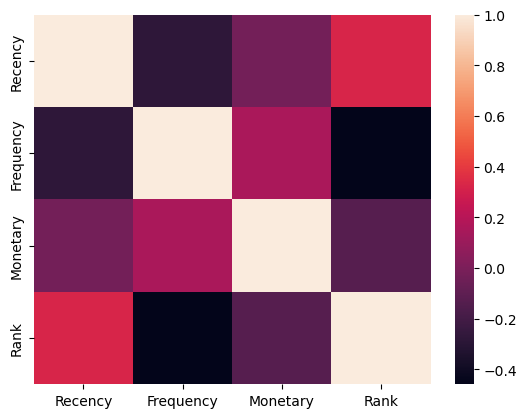

In [42]:
sns.heatmap(rfm_data.corr())

On one hand, we have a negative correlation between:
- Recency and Frequency
- Recency and Monetary

On the other hand, the correlation between **Monetary and Frequency** is positive comparing to negative ones but still not that strong. 

#### Visualize feature distributions

To get a better understanding of the dataset, we can construct a scatter matrix of each of the three features present in the RFM data. 

In [ ]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(rfm_data, alpha = 0.3, figsize = (11,5), diagonal = 'kde');

We can notice that we have a **skewed distribution** of the 3 variables and there exist **outliers**.

This indicates how normalization is required to make the data features normally distributed as **clustering** algorithms **require** them to be **normally distributed**.

#### Data Normalization

In [44]:
#log transformation
rfm_r_log = np.log(rfm_data['Recency']+0.1) #can't take log(0) and so add a small number
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [45]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

In [46]:
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,5.784133,0.000000
12747.0,6.490708,0.741937,2.302585
12748.0,8.226662,-2.302585,5.278115
12749.0,4.589549,1.131402,1.609438
12820.0,4.065602,1.131402,1.386294


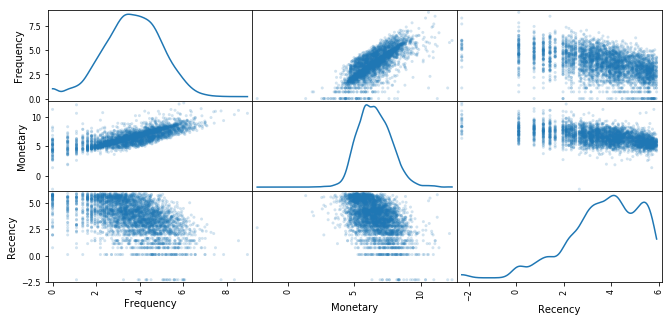

In [161]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(log_data, alpha = 0.2, figsize = (11,5), diagonal = 'kde');

The distributions of Frequency and Monetary are better, more normalized, but it's not the case with Recency Distribution, which is improved but not as much. 

<Axes: >

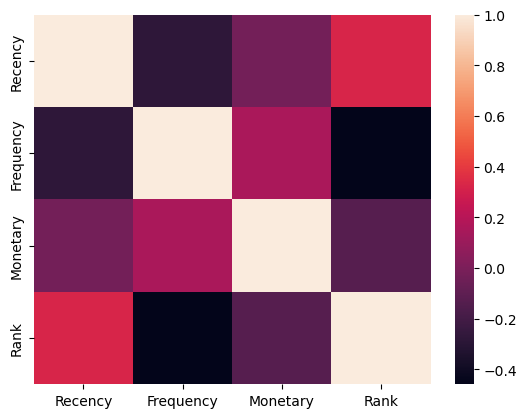

In [47]:
sns.heatmap(rfm_data.corr())

<Axes: >

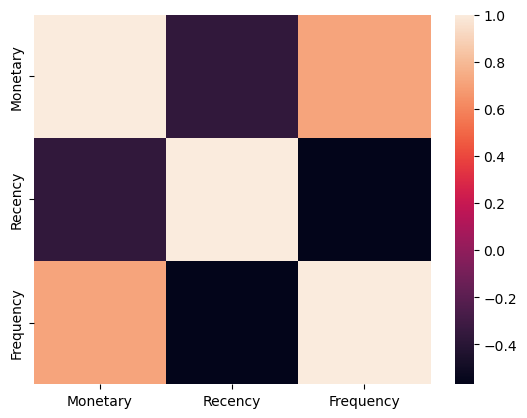

In [48]:
sns.heatmap(log_data.corr())

In [49]:
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.364351,0.715609
Recency,-0.364351,1.000000,-0.569951
Frequency,0.715609,-0.569951,1.000000


Now, Monetary and Frequency are more strongly correlated.

### K-means Implementation

A common challenge with k-means is that you must tell it how many clusters you expect. Figuring out how many clusters we need is not obvious from data, thus we will try different clusters numbers and check their [silhouette coefficient](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). The [elbow](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method) method can be used to determine the number of clusters as well.

**Note:** K-means is sensitive to initializations because those initializations are critical to quality of optima found. Thus, we will use smart initialization called ***k-means++***.

In [ ]:
matrix = log_data.as_matrix()
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

The **best silhouette score** obtained is when the **number of clusters is 2**.

In [204]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.393


#### Visualize Clusters

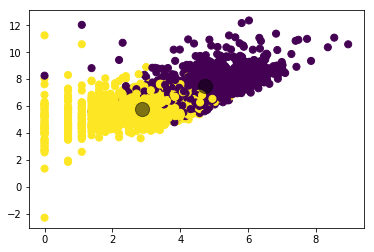

In [205]:
#create a scatter plot
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='viridis')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [222]:
# What's the number of customers in each cluster?
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T

,1,0
nb. de clients,2243,1620


**Note(Additional):** We can check the median of each variable (Frequency, Monetary, Recency) in each cluster in order to understand what customers does each cluster represent.

**Conclusion - Perspective after applying k-means clustering**:

Unfortunately, we didn't obtain a clearly separated clusters. Clusters assignments are muddled. (It may be due to outliers who weren't removed).

Limitations of k-means clustering:
- There is no assurance that it will lead to the ***global*** best solution.
- Can't deal with **different shapes**(not circular) and consider one point's probability of belonging to more than one cluster.

These disadvantages of k-means mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope. Here comes Guassian Mixture Model (GMM) in help by providing greater flexibility due to clusters having unconstrained covariances and allowing probabilistic cluster assignment.

Reference  ***Python Data Science Handbook*** by ***Jake VanderPlas***.

**Note- Further Explanation:** A common practice before doing clustering: **Principal Component Analysis (PCA)**. PCA calculates the dimensions which best maximize variance.It gives directions on how many components to consider for GMM. Basically, it does **dimensionality reduction** while keeping the most important features, characteristics (combinations of features best describe customers). But as we are not dealing with high dimension we won't do it for this case.

### Gaussian Mixture Model Implementation

While k-means is easy to understand and implement.It fails when dealing with non-circular shapes and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

/home/sarahm/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/sarahm/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/sarahm/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/sarahm/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecatio

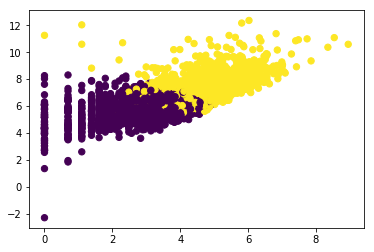

In [210]:
gmm = GMM(n_components=2).fit(matrix)
labels = gmm.predict(matrix)
plt.scatter(matrix[:, 0], matrix[:, 1], c=labels, s=40, cmap='viridis');